In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

In [5]:
stockdf = pd.read_csv("stock_market_data-AAL.csv",index_col=1, parse_dates=True, squeeze=True)
# stockdf = stockdf.sort_values(by=['Date'])[["Date", "Low", "High", "Open"]]
stockdf = stockdf.sort_index()[[ "Low", "High", "Open", "Close"]]
stockdf.head(5)

,Low,High,Open,Close
Date,,,,
2005-09-27,19.10,21.40,21.05,19.30
2005-09-28,19.20,20.53,19.30,20.50
2005-09-29,20.10,20.58,20.40,20.21
2005-09-30,20.18,21.05,20.26,21.01
2005-10-03,20.90,21.75,20.90,21.50


<AxesSubplot:xlabel='Date'>

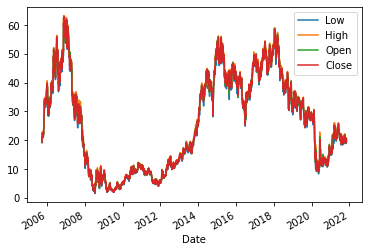

In [22]:
stockdf.plot()

<AxesSubplot:xlabel='Date'>

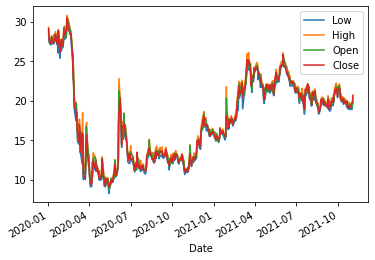

In [21]:
stockdf["2020" : "2021"].plot()

we see all the graphs follow the same pattern

it is clearly not stationary

In [23]:
len(stockdf)

4055

In [6]:
g=stockdf["Close"].values
result=adfuller(g)
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print(' Citical Values:')
for key , value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.694929
p-value : 0.433727
 Citical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Since ADF statistics is larger, we will accet H0 that time series is non-stationary

below is TSF template

default activation used is tanh

In [400]:
def do_difference(data, time_diff=1):
    df = []
    for row in range(time_diff, len(data)):
        df.append(data[row] - data[row - time_diff])
    return np.array(df)

def invert_difference(differenced_data, y_values):
    undiff = []
    index_to_start = len(differenced_data) + 1

    for i in range(len(differenced_data)):
        undiff.append(differenced_data[i] + y_values[-(index_to_start - i)])
    return undiff
    

def do_scaling(data):

    scaler = MinMaxScaler()
    scaler = scaler.fit(data.reshape(-1,1))
    scaledf = scaler.transform(data.reshape(-1,1))
    scaledf = scaledf.reshape(scaledf.shape[0])
    return scaler, scaledf

def invert_scaling(scaler, data):
    return scaler.inverse_transform(data).reshape(data.shape[0])
        

# given we have values of closing price for past 5 days, we want to predict the price of next day
def generate_sequence(data, lookback, target_col=None):
    traindf = []
    targetdf = []
    for i in range(len(data)):
        till_index = i +lookback
        if till_index <= len(data)-1:
            traindf.append(data[i: i + lookback])
            if target_col == None:
                targetdf.append(data[i+ lookback])
            else:
                targetdf.append(data[i+ lookback][target_col])
    return np.array(traindf), np.array(targetdf)


def train_test_split(x, y, train_percent=0.8):
    test_start_index = round(train_percent*len(x))
    trainx, trainy, testx, testy = x[0:test_start_index], y[0:test_start_index], x[test_start_index:], y[test_start_index:]
    return trainx, trainy, testx, testy

def lstm_model(trainx, trainy, neurons, lookback, features, epochs,batch_size=1, activation_func = "tanh"):
    X, y = trainx, trainy
    model = Sequential()
    # model.add(LSTM(4, activation='relu', input_shape=(n_steps, n_features)))
    model.add(LSTM(neurons, batch_input_shape=(batch_size,lookback, features), stateful=True))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mean_squared_error')
    # X = X.reshape((X.shape[0], X.shape[1], n_features))
    X = X.reshape((X.shape[0], X.shape[1], features)) 
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False)
    return history, model

def plot_model_results(model):
    loss = model.history["loss"]
    plt.plot(loss)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.show()
    # return loss

def bidirectional_model(trainx, trainy, input_neurons, hidden_neurons, lookback, features, epochs,batch_size=128, dropout=0.5):
    X, y = trainx, trainy
    model = Sequential()
    model.add(Bidirectional(LSTM(input_neurons,return_sequences=True, dropout=0.5, input_shape=(lookback, features))))
    model.add(Bidirectional(LSTM(hidden_neurons, dropout=0.5)))
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mean_squared_error')
    X = X.reshape((X.shape[0], X.shape[1], features))
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False)
    return history, model

def GRU_model(trainx, trainy, input_neurons, hidden_neurons, lookback, features, epochs,batch_size=128, dropout=0.5):
    X, y = trainx, trainy
    model = Sequential()
    model.add(GRU (input_neurons, dropout=0.5, return_sequences = True, input_shape=(lookback, features)))
    model.add(GRU(hidden_neurons, dropout=0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    X = X.reshape((X.shape[0], X.shape[1], features))
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False)
    return history, model

def predict_data(model, testx, features=1):
    predictx = testx.reshape(testx.shape[0], testx.shape[1], features)
    y_pred = model.predict(predictx,batch_size=1)
    return y_pred

def plot_predicted(testy, y_pred, original_y, model_name, scaler):
    
    y_pred_unscaled = scaler.inverse_transform(y_pred)
    testy_unscaled = scaler.inverse_transform(testy.reshape(testy.shape[0],1))
    testy_undiff = invert_difference(testy_unscaled,original_y)
    pred_y_undiff = invert_difference(y_pred_unscaled, original_y)
    plt.plot(testy_undiff, label="Actual")
    plt.plot(pred_y_undiff, label="Predicted")
    plt.legend(loc="best")
    plt.title("Model Name = " + str(model_name))

def evaluate_results(testy, y_pred, original_y, model_name, scaler):
    errors = y_pred - testy
    rmse = np.sqrt(np.square(errors).mean())
    mae = np.mean(np.abs(errors))
    print('Root Mean Square Error = ' + str(rmse))
    print("mean Absolute Error = " + str(mae))
    plot_predicted(testy, y_pred, original_y, model_name, scaler)

we will be predicting the closing price

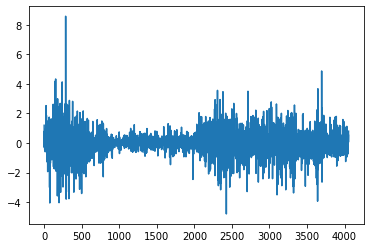

In [200]:
newdf = do_difference(stockdf["Close"])
plt.plot(newdf)
plt.show()

In [78]:
newdf

array([ 1.2 , -0.29,  0.8 , ...,  0.57,  0.06,  0.8 ])

In [201]:
scaler, scaledf = do_scaling(newdf)

### Given we have past 5 days closing prices, predict the next day's closing price. 

In [202]:
dfx, dfy = generate_sequence(newdf, 5)

In [262]:
trainx, trainy, testx, testy = train_test_split(dfx, dfy)

In [204]:
trainx.shape

(3239, 5)

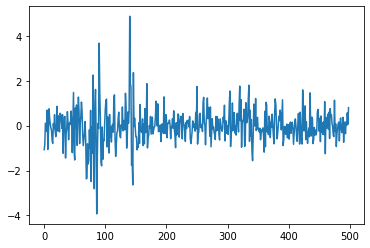

In [154]:
plt.plot(testy)

### Neurons = 50

### past data taken = 5

### features = 1

### epochs = 30

In [401]:
history, model1 = lstm_model(trainx,trainy,50,5,1,30)

Epoch 1/30
3239/3239 [==============================] - 18s 5ms/step - loss: 0.6818
Epoch 2/30
3239/3239 [==============================] - 14s 4ms/step - loss: 0.6793
Epoch 3/30
3239/3239 [==============================] - 14s 4ms/step - loss: 0.6792
Epoch 4/30
3239/3239 [==============================] - 15s 4ms/step - loss: 0.6778
Epoch 5/30
3239/3239 [==============================] - 14s 4ms/step - loss: 0.6858
Epoch 6/30
3239/3239 [==============================] - 14s 4ms/step - loss: 0.6828
Epoch 7/30
3239/3239 [==============================] - 15s 5ms/step - loss: 0.6799
Epoch 8/30
3239/3239 [==============================] - 15s 5ms/step - loss: 0.6780
Epoch 9/30
3239/3239 [==============================] - 14s 4ms/step - loss: 0.6773
Epoch 10/30
3239/3239 [==============================] - 14s 4ms/step - loss: 0.6764
Epoch 11/30
3239/3239 [==============================] - 13s 4ms/step - loss: 0.6757
Epoch 12/30
3239/3239 [==============================] - 14s 4ms/step - lo

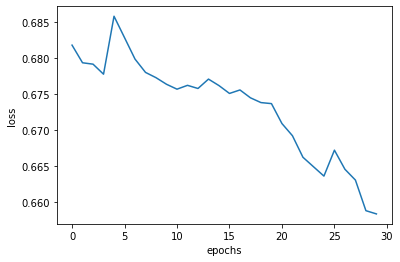

In [402]:
plot_model_results(history)

### Input Neurons = 64

### hidden Neurons = 20

### past data taken = 5

### features = 1

### epochs = 30

In [361]:
history2, model2 = bidirectional_model(trainx, trainy, 64,20,5,1,30,)

Epoch 1/30
26/26 [==============================] - 6s 11ms/step - loss: 0.6799
Epoch 2/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6794
Epoch 3/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6777
Epoch 4/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6768
Epoch 5/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6782
Epoch 6/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6805
Epoch 7/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6775
Epoch 8/30
26/26 [==============================] - 0s 11ms/step - loss: 0.6781
Epoch 9/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6769
Epoch 10/30
26/26 [==============================] - 0s 11ms/step - loss: 0.6782
Epoch 11/30
26/26 [==============================] - 0s 10ms/step - loss: 0.6785
Epoch 12/30
26/26 [==============================] - 0s 11ms/step - loss: 0.6762
Epoch 13/30
26/26 [==================

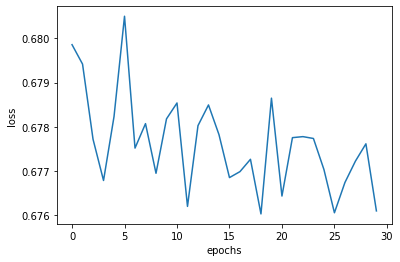

In [362]:
plot_model_results(history2)

### Input Neurons = 64

### Hidden Neurons = 20

### past data taken = 48

### features = 1

### epochs = 30

In [365]:
history3 , model3 = GRU_model(trainx, trainy, 64,20,5,1,30,)

Epoch 1/30
26/26 [==============================] - 3s 8ms/step - loss: 0.6829
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6790
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6780
Epoch 4/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6793
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6781
Epoch 6/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6790
Epoch 7/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6787
Epoch 8/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6814
Epoch 9/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6803
Epoch 10/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6784
Epoch 11/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6761
Epoch 12/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6791
Epoch 13/30
26/26 [==============================

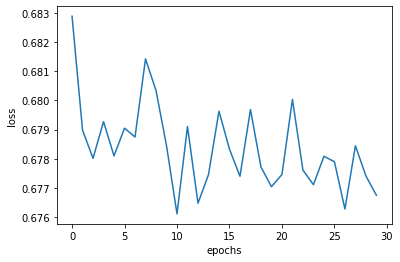

In [366]:
plot_model_results(history3)

In [403]:
lstm_pred = predict_data(model1,testx)
bidirec_pred= predict_data(model2,testx)
gru_pred = predict_data(model3,testx)

Root Mean Square Error = 0.8100368049086295
mean Absolute Error = 0.5801960250614406


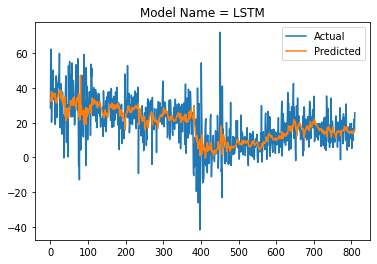

In [405]:
evaluate_results(testy,lstm_pred,stockdf["Close"], "LSTM", scaler)

Root Mean Square Error = 0.7997628004939377
mean Absolute Error = 0.5701462133378901


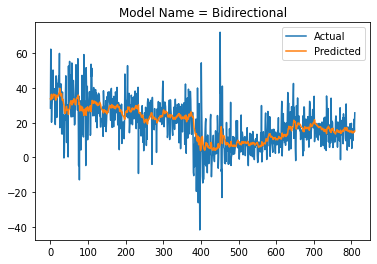

In [406]:
evaluate_results(testy,bidirec_pred,stockdf["Close"], "Bidirectional", scaler)

Root Mean Square Error = 0.7996636474562685
mean Absolute Error = 0.5701416596516753


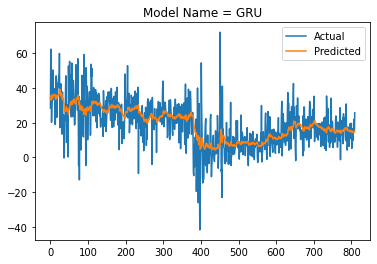

In [407]:
evaluate_results(testy,gru_pred,stockdf["Close"], "GRU", scaler)

As shown in the graphs, the model did not predict very accurately. The orange line in the graph clearly  did not predict spikes really well. Although the RMSE is close to quite good, it seems it can predict the trend quite well. Maybe by changing the number of neurons, or lookack value (lag) might decrease RMSE more and will lead to a better prediction